In [2]:
Sys.setlocale("LC_ALL", "es_ES.UTF-8") # principlamente para mostrar tildes en las gráficas

library(MASS)
library(ISLR)
library(dplyr)
library(glmnet)
library(caret)
library(ggplot2)

[1] "es_ES.UTF-8/es_ES.UTF-8/es_ES.UTF-8/C/es_ES.UTF-8/C"


Adjuntando el paquete: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Cargando paquete requerido: Matrix

Loaded glmnet 4.1-8

Cargando paquete requerido: ggplot2

Cargando paquete requerido: lattice



## Descenso de gradiente

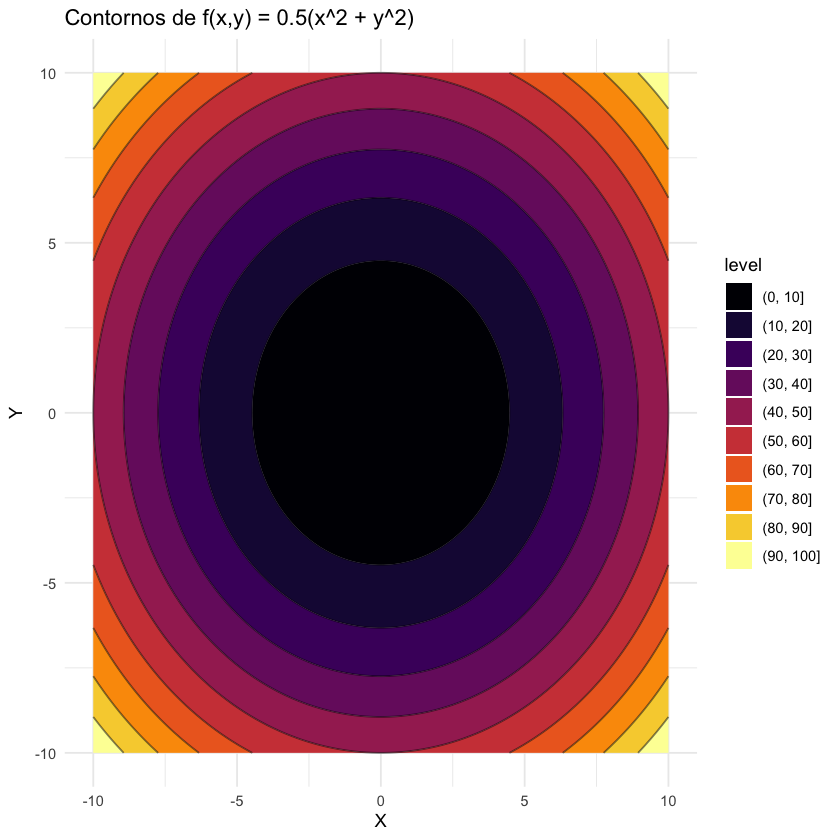

In [118]:
# funcion objetivo
f <- function(x, y) {
    return(0.5 * (x^2 + y^2))
}

# gradiente de la función objetivo
gradiente <- function(punto) {
    return(c(punto[1], punto[2]))
}


x_seq <- seq(-10, 10, length.out = 100)
y_seq <- seq(-10, 10, length.out = 100)
df <- expand.grid(x = x_seq, y = y_seq)
df$z <- 0.5 * (df$x^2 + df$y^2)

library(ggplot2)
ggplot(df, aes(x = x, y = y, z = z)) + geom_contour_filled() + geom_contour(color = "black", alpha = 0.5) + 
scale_fill_viridis_d(option='inferno') + 
theme_minimal() + labs(title = "Contornos de f(x,y) = 0.5(x^2 + y^2)", x = "X", y = "Y")

Con el método de descenso de grandiente buscamos la solución al problema de optimización de forma iterativa, usando como dirección de búsqueda el gradiente negativo de la función objetivo. Fijaremos como criterio de parada que $||\nabla f(x)\||^2$ sea menor que un cierto valor. Implementamos el algoritmo usando un paso fijo y un paso variable (con *exact search line*), que usa un paso variable $t = \underset{s \geq 0}{\text{argmin}} f(x + s\Delta x)$

Punto final: 0.002620041 0.001310021 
Valor función: 4.290384e-06 
Iteraciones: 64 


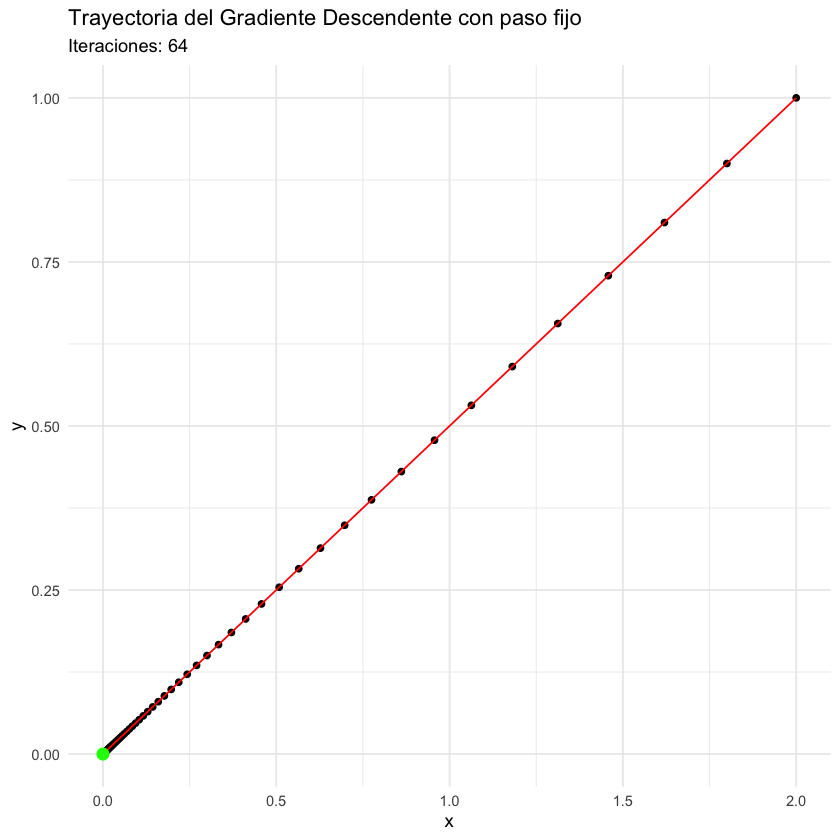

Punto final: 0 0 
Valor función: 0 
Iteraciones: 2 


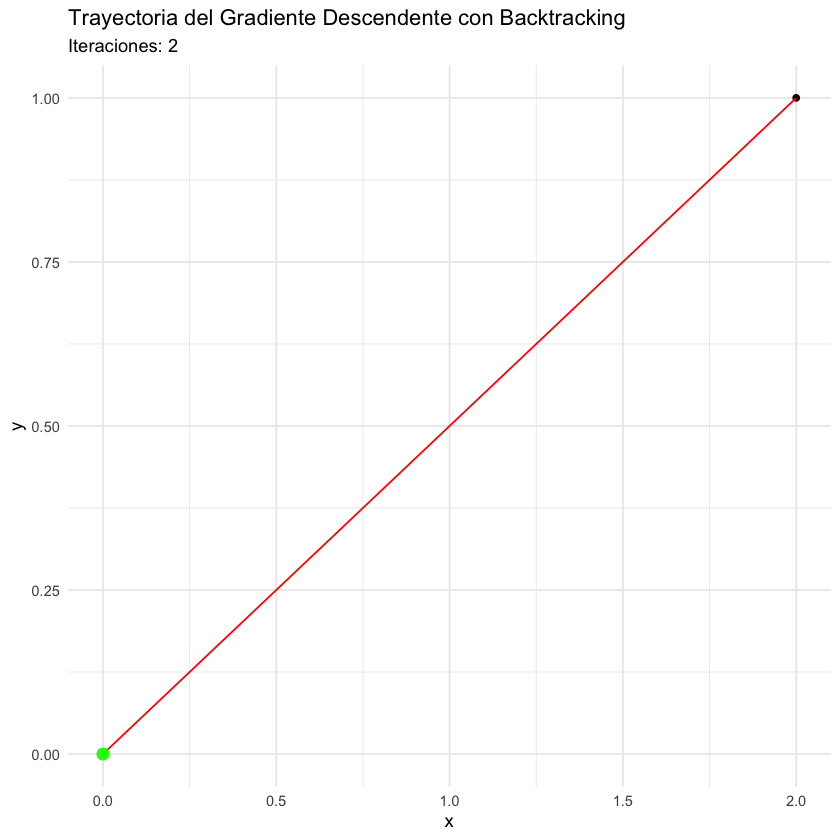

Punto final: 0 0 
Valor función: 0 
Iteraciones: 2 


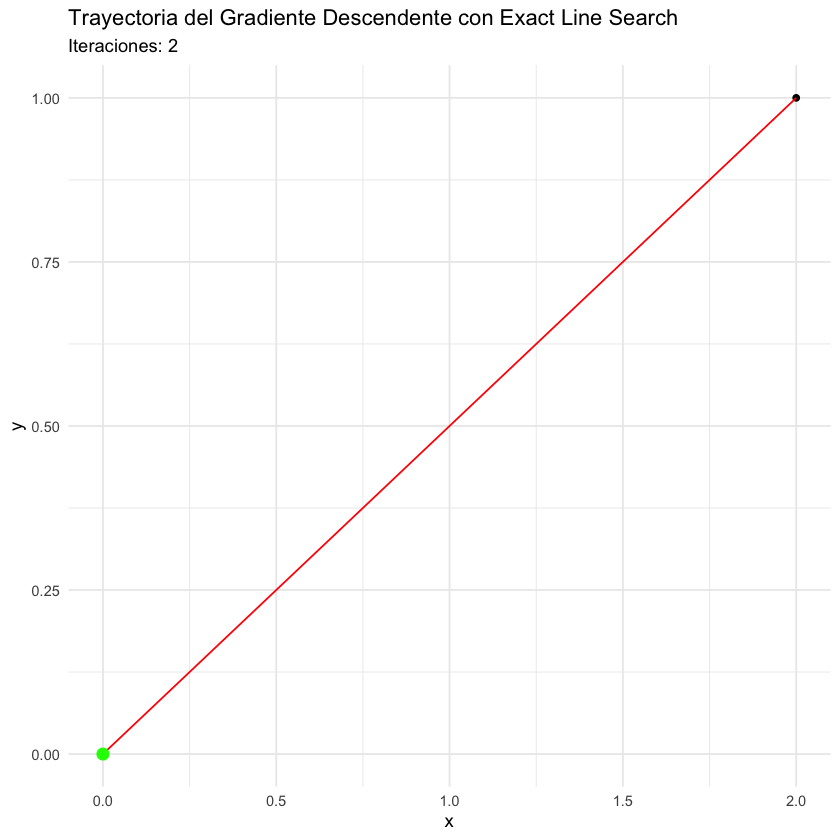

In [134]:
# exact line search (el ejemplo de clase tomando gamma = 1)
exact_step <- function(punto, dir, gamma = 1) {
    x <- punto[1]
    y <- punto[2]
    return((gamma^2*y^2 + x^2)/(gamma^3*y^2 + x^2)) 
}

# backtracking
backtracking_step <- function(punto, dir, alpha, beta, t = 1) {
    f0 <- f(punto[1], punto[2])
    
    while(f(punto[1] + t*dir[1], punto[2] + t*dir[2]) > 
          f0 - alpha*t*sum(dir^2)) {
        t <- beta * t
    }
    
    return(t)
}

# algoritmo de descenso de gradiente
descenso_gradiente <- function(punto_inicial, alpha = 0.1, tolerancia = 1e-5, max_iter = 1000, search = 'fijo') {
    punto_actual <- punto_inicial
    trayectoria <- matrix(punto_actual, ncol = 2)
    
    for(i in 1:max_iter) {
        dir <- -gradiente(punto_actual) # la dirección es el gradiente negativo
        
        # criterio de parada
        if(sum(dir^2) < tolerancia) {
            break
        }
        
        # paso (exact search o paso fijo)
        if(search == 'exact') {
            paso <- exact_step(punto_actual, dir)
        } else if(search == 'backtracking') {
            paso <- backtracking_step(punto_actual, dir, alpha, beta)
        } else {
            paso <- alpha
        }
        
        punto_actual <- punto_actual + paso * dir
        trayectoria <- rbind(trayectoria, punto_actual)
    }
    
    return(list(solucion = punto_actual, trayectoria = trayectoria, iteraciones = i, 
                valor_final = f(punto_actual[1], punto_actual[2])))
}


punto_inicial <- c(2, 1)
resultado <- descenso_gradiente(punto_inicial)
resultado_back <- descenso_gradiente(punto_inicial, search = 'backtracking')
resultado_esl <- descenso_gradiente(punto_inicial, search = 'exact')


df_trayectoria <- data.frame(x = resultado$trayectoria[,1], y = resultado$trayectoria[,2])
df_trayectoria_back <- data.frame(x = resultado_back$trayectoria[,1], y = resultado_back$trayectoria[,2])
df_trayectoria_esl <- data.frame(x = resultado_esl$trayectoria[,1], y = resultado_esl$trayectoria[,2])

ggplot(df_trayectoria, aes(x = x, y = y)) + geom_point() + geom_path(color = "red") + 
geom_point(data = data.frame(x = 0, y = 0), color = "green", size = 3) + 
labs(title = "Trayectoria del Gradiente Descendente con paso fijo", 
     subtitle = paste("Iteraciones:", resultado$iteraciones)) + 
theme_minimal()

#resultados paso fijo
cat("Punto final:", resultado$solucion, "\n")
cat("Valor función:", resultado$valor_final, "\n")
cat("Iteraciones:", resultado$iteraciones, "\n")



ggplot(df_trayectoria_back, aes(x = x, y = y)) + geom_point() + geom_path(color = "red") +
geom_point(data = data.frame(x = 0, y = 0), color = "green", size = 3) +
labs(title = "Trayectoria del Gradiente Descendente con Backtracking",
     subtitle = paste("Iteraciones:", resultado_back$iteraciones)) +
theme_minimal()

#resultados backtracking
cat("Punto final:", resultado_back$solucion, "\n")
cat("Valor función:", resultado_back$valor_final, "\n")
cat("Iteraciones:", resultado_back$iteraciones, "\n")



ggplot(df_trayectoria_esl, aes(x = x, y = y)) + geom_point() + geom_path(color = "red") + 
geom_point(data = data.frame(x = 0, y = 0), color = "green", size = 3) +
labs(title = "Trayectoria del Gradiente Descendente con Exact Line Search",
     subtitle = paste("Iteraciones:", resultado_esl$iteraciones)) +
theme_minimal()

#resultados exact search
cat("Punto final:", resultado_esl$solucion, "\n")
cat("Valor función:", resultado_esl$valor_final, "\n")
cat("Iteraciones:", resultado_esl$iteraciones, "\n")

# Regresión

El modelo de regresión lineal toma la forma 
\begin{equation}
Y = \beta_0 + \sum_{j = 1}^p \beta_j X_j + \epsilon
\end{equation}

Estimamos los coeficientes $\beta$ minimizando el RSS
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2
\end{equation}

Con regresión Ridge y Lasso añadimos un término de regularización con un coeficiente $\lambda$. En Ridge minimizamos
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2 + \lambda \sum_{j = 1}^p \beta_j^2
\end{equation}

En Lasso minimizamos
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2 + \lambda \sum_{j = 1}^p |\beta_j|
\end{equation}

Lasso puede reducir algunos coeficientes a 0, mientras que Ridge no.

### Hitters

[1] "Intervalos de confianza al 95%:"


,2.5 %,97.5 %
(Intercept),-144.342027,160.732256
Hits,3.798535,6.455949



Call:
lm(formula = Salary ~ Hits, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-786.57 -234.07  -66.17  149.62 2114.01 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.1951    77.3508   0.106    0.916    
Hits          5.1272     0.6738   7.610 1.09e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 418.4 on 198 degrees of freedom
Multiple R-squared:  0.2263,	Adjusted R-squared:  0.2224 
F-statistic: 57.91 on 1 and 198 DF,  p-value: 1.092e-12


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


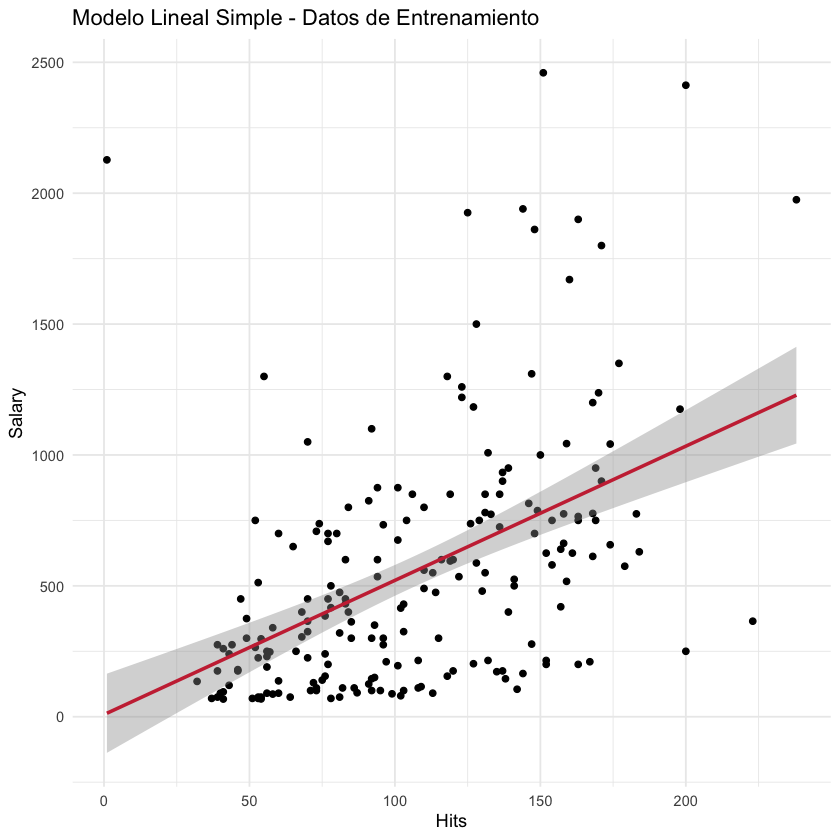

,2.5 %,97.5 %
(Intercept),-81.5240989,294.5838143
AtBat,-4.6119085,-1.4036256
Hits,4.8508976,16.2562990
HmRun,-16.4897463,11.6874473
Runs,-8.6412674,5.3813735
RBI,-5.7408796,6.1344099
Walks,2.2953035,10.5488310
Years,-25.5674110,28.4985645
CAtBat,-0.4574467,0.1377415
CHits,-1.8633315,1.1109960



Call:
lm(formula = Salary ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-724.32 -176.70  -42.04  125.87 1908.21 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 106.52986   95.31314   1.118 0.265168    
AtBat        -3.00777    0.81304  -3.699 0.000286 ***
Hits         10.55360    2.89035   3.651 0.000340 ***
HmRun        -2.40115    7.14065  -0.336 0.737057    
Runs         -1.62995    3.55361  -0.459 0.647013    
RBI           0.19677    3.00943   0.065 0.947941    
Walks         6.42207    2.09161   3.070 0.002463 ** 
Years         1.46558   13.70138   0.107 0.914933    
CAtBat       -0.15985    0.15083  -1.060 0.290631    
CHits        -0.37617    0.75375  -0.499 0.618337    
CHmRun        0.29513    1.84025   0.160 0.872762    
CRuns         2.10611    0.85595   2.461 0.014800 *  
CRBI          1.00458    0.77352   1.299 0.195676    
CWalks       -0.87361    0.37143  -2.352 0.019735 *  
PutOuts       0.42170    0.09867   

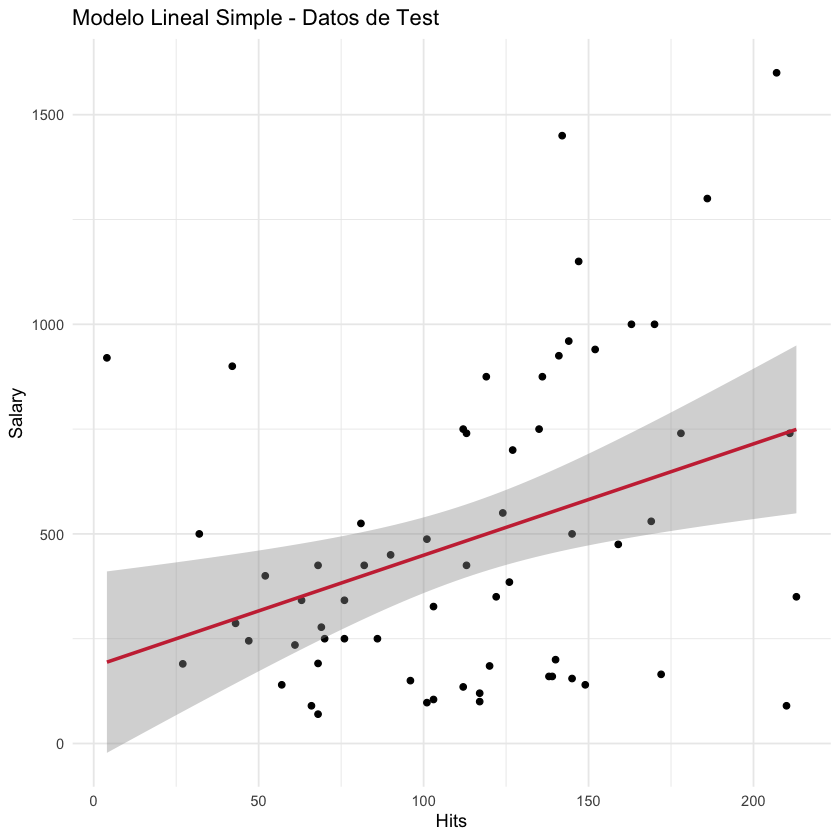

[1] 2.66

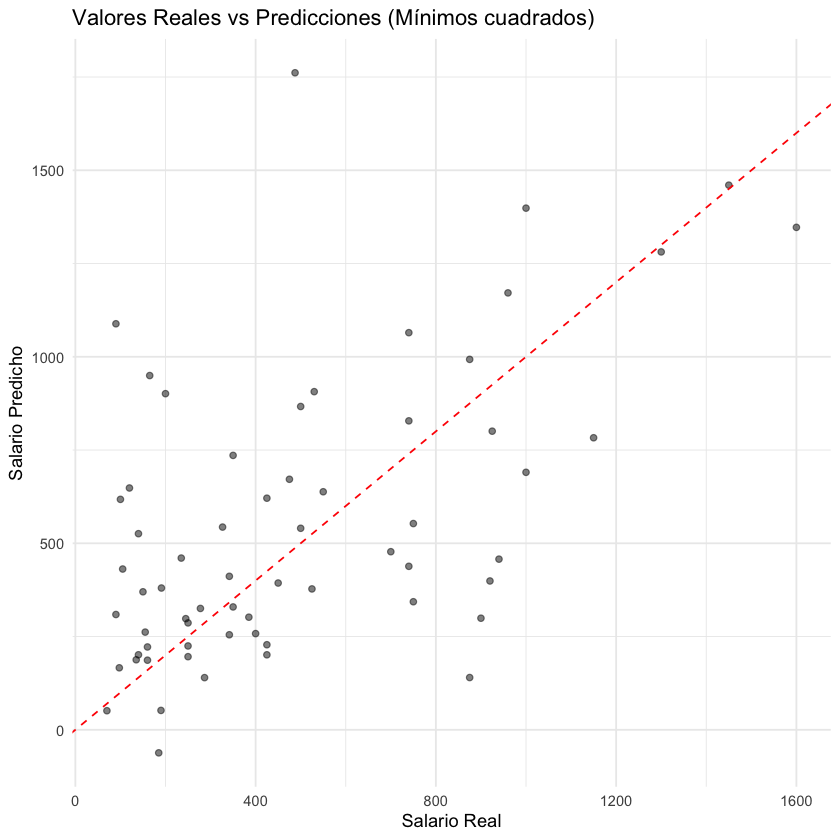

[1] 1.08

17 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) 88.9274112
AtBat       -2.7017176
Hits         9.2083457
HmRun       -3.4108465
Runs         .        
RBI          0.1971089
Walks        5.6346801
Years       -1.2245797
CAtBat      -0.1401156
CHits        .        
CHmRun       1.3707597
CRuns        1.3512298
CRBI         0.5241207
CWalks      -0.6641234
PutOuts      0.4085601
Assists      0.5955877
Errors      -4.0035427

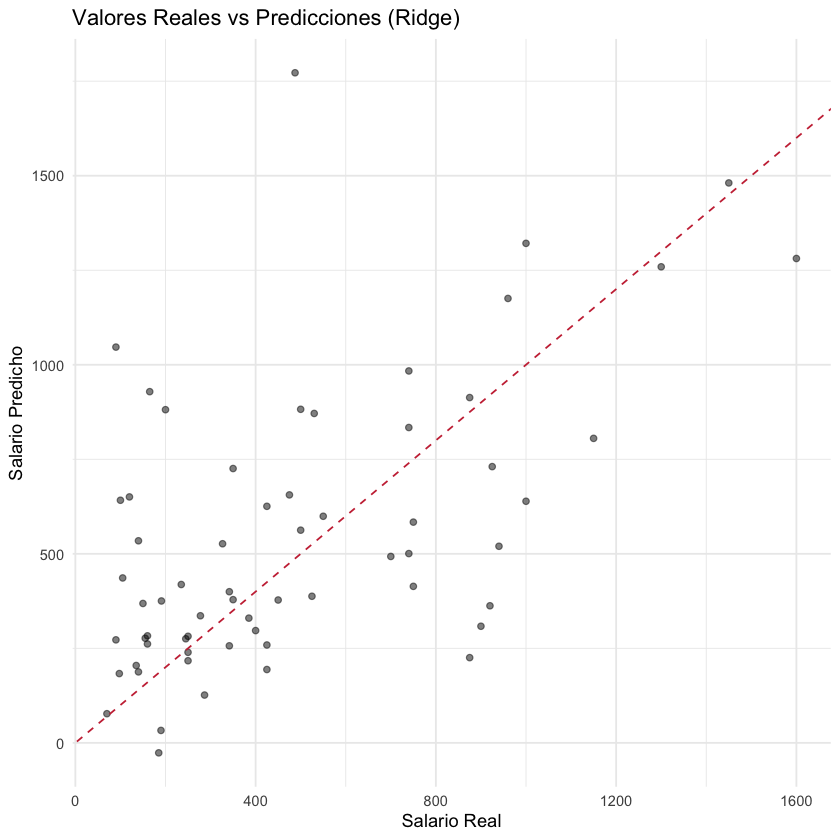

     Model Train_RSE Train_MSE Train_RMSE  Train_R2 Test_RSE Test_MSE Test_RMSE
1   Simple  418.4460 173346.07   416.3485 0.2262813 380.8775 140462.3  374.7830
2 Multiple  318.0044  92531.03   304.1891 0.5869938 415.8548 126270.1  355.3451
3    Ridge  320.3720  93914.00   306.4539 0.5808211 404.3763 119395.7  345.5368
4    Lasso  319.1305  93187.49   305.2663 0.5840638 406.3480 120562.8  347.2216
      Test_R2
1 -0.06696709
2  0.04083828
3  0.09305723
4  0.08419156


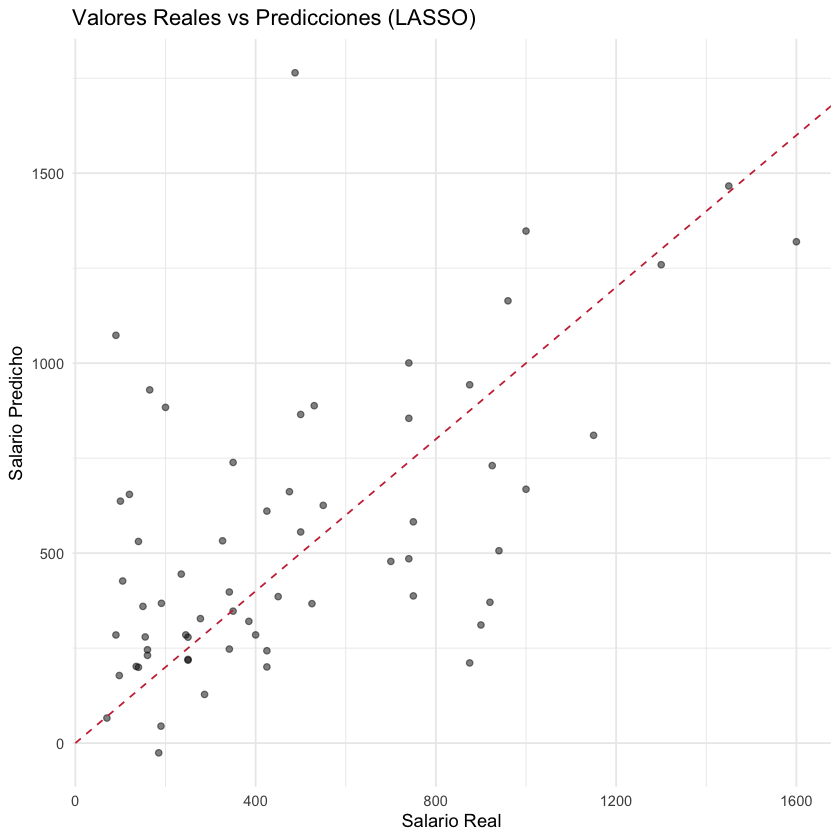

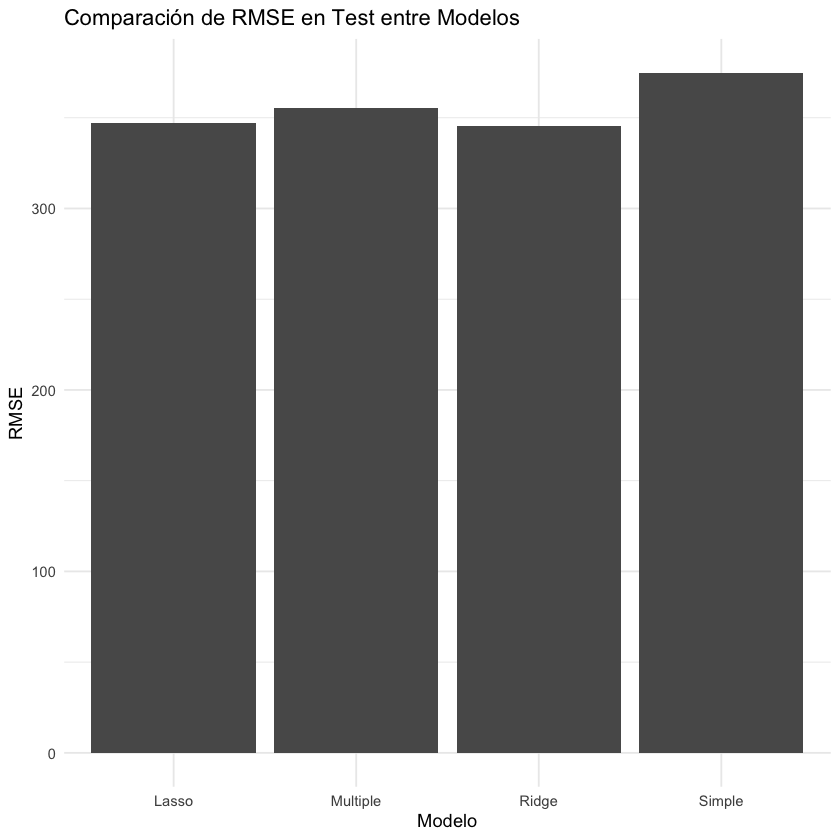

Importance of components:
                          Comp.1    Comp.2    Comp.3    Comp.4     Comp.5
Standard deviation     2.7733967 2.0302601 1.3148557 0.9575410 0.84109683
Proportion of Variance 0.4524547 0.2424680 0.1016968 0.0539344 0.04161435
Cumulative Proportion  0.4524547 0.6949227 0.7966195 0.8505539 0.89216822
                           Comp.6     Comp.7     Comp.8     Comp.9     Comp.10
Standard deviation     0.72374220 0.69841796 0.50090065 0.42525940 0.363901982
Proportion of Variance 0.03081193 0.02869339 0.01475891 0.01063797 0.007789685
Cumulative Proportion  0.92298014 0.95167354 0.96643244 0.97707042 0.984860104
                           Comp.11     Comp.12     Comp.13     Comp.14
Standard deviation     0.312011679 0.243641510 0.232044829 0.163510472
Proportion of Variance 0.005726546 0.003491834 0.003167341 0.001572687
Cumulative Proportion  0.990586651 0.994078485 0.997245826 0.998818513
                            Comp.15      Comp.16      Comp.17
Standard deviati

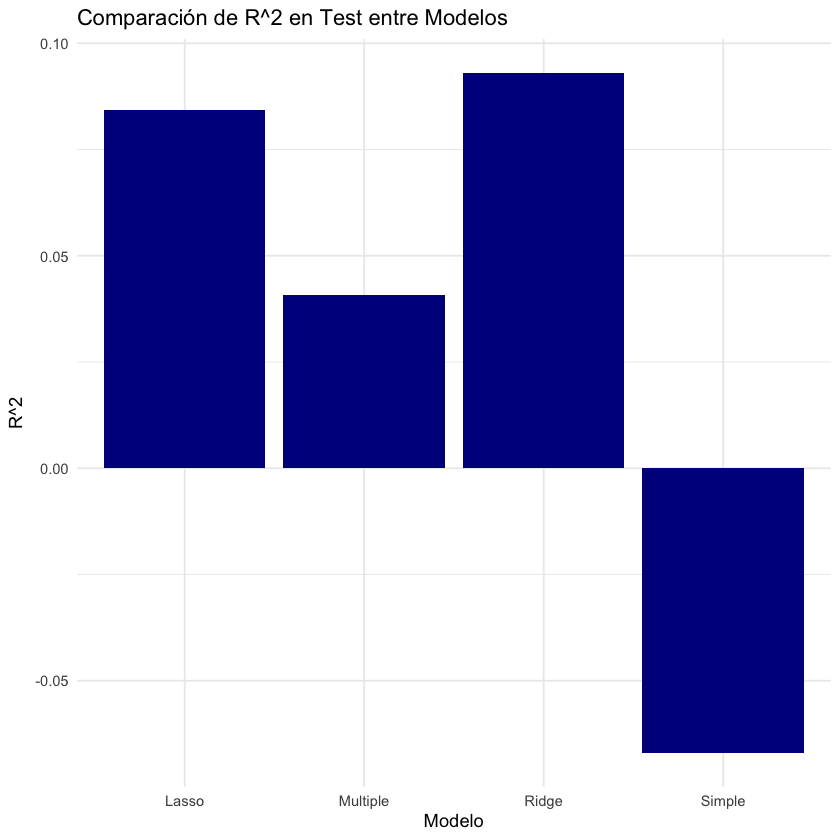

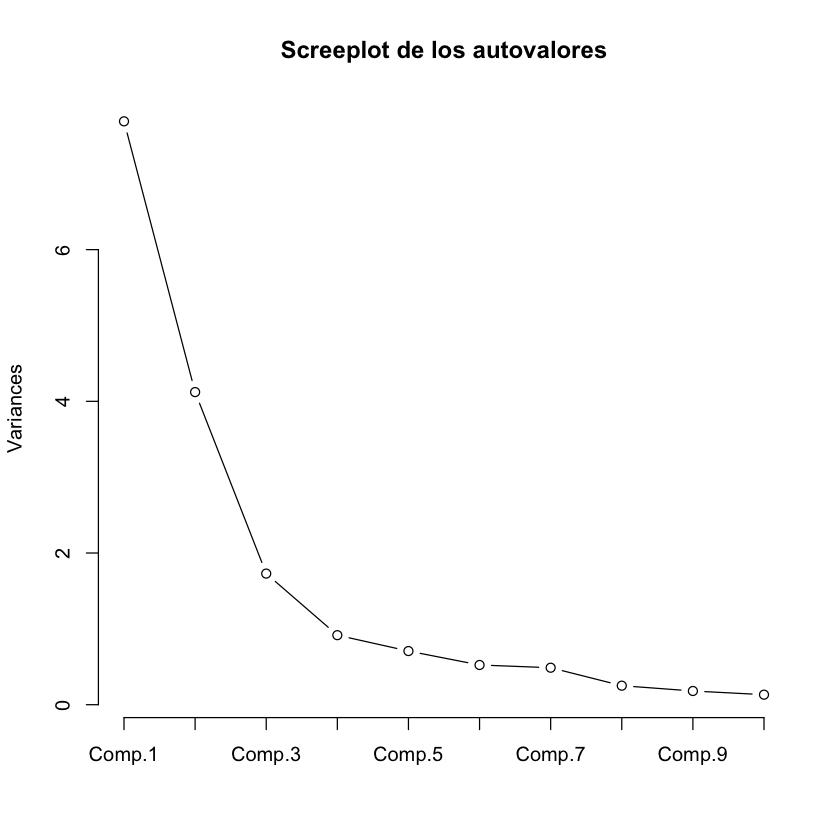

Hitters                  package:ISLR                  R Documentation

_B_a_s_e_b_a_l_l _D_a_t_a

_D_e_s_c_r_i_p_t_i_o_n:

     Major League Baseball Data from the 1986 and 1987 seasons.

_U_s_a_g_e:

     Hitters
     
_F_o_r_m_a_t:

     A data frame with 322 observations of major league players on the
     following 20 variables.

     ‘AtBat’ Number of times at bat in 1986

     ‘Hits’ Number of hits in 1986

     ‘HmRun’ Number of home runs in 1986

     ‘Runs’ Number of runs in 1986

     ‘RBI’ Number of runs batted in in 1986

     ‘Walks’ Number of walks in 1986

     ‘Years’ Number of years in the major leagues

     ‘CAtBat’ Number of times at bat during his career

     ‘CHits’ Number of hits during his career

     ‘CHmRun’ Number of home runs during his career

     ‘CRuns’ Number of runs during his career

     ‘CRBI’ Number of runs batted in during his career

     ‘CWalks’ Number of walks during his career

     ‘League’ A factor with 

In [ ]:
data("Hitters")
hitters_clean <- na.omit(Hitters) %>% select(-League, -Division, -NewLeague)
#set.seed(123)
#train_index <- createDataPartition(hitters_clean$Salary, p = 0.8, list = FALSE)
#train <- hitters_clean[train_index,]
#test <- hitters_clean[-train_index,]

train <- hitters_clean[1:200,]
test <- hitters_clean[(200 + 1):nrow(hitters_clean), ]


# REGRESION LINEAL SIMPLE

simple_model <- lm(Salary ~ Hits, data = train) # para ajustar un modelo con mas predictores Hits + CHits

print("Intervalos de confianza al 95%:")
confint(simple_model, level = 0.95) # intervalos de confianza
summary(simple_model)

train_pred_simple <- predict(simple_model)
test_pred_simple <- predict(simple_model, newdata = test)

#pintamos los datos y sobre ellos la recta de regresión 
plotRLS_train <- ggplot(train, aes(x = Hits, y = Salary)) + geom_point() + 
                 geom_smooth(method = "lm", se = TRUE, color="#ca3142") + 
                 labs(title = "Modelo Lineal Simple - Datos de Entrenamiento") + theme_minimal()

plotRLS_test <- ggplot(test, aes(x = Hits, y = Salary)) + geom_point() + 
                geom_smooth(method = "lm", se = TRUE, color="#ca3142") + 
                labs(title = "Modelo Lineal Simple - Datos de Test") + theme_minimal()

plotRLS_train
plotRLS_test



# REGRESION MULTILINEAL

multi_model <- lm(Salary ~ ., data = train)
confint(multi_model, level = 0.95) # intervalos de confianza
summary(multi_model)

train_pred_multi <- predict(multi_model)
test_pred_multi <- predict(multi_model, newdata = test)

# comparacion valor esperado - valor predicho
plotLSS <- ggplot(data = data.frame(real = test$Salary, pred = test_pred_multi), aes(x = real, y = pred)) +
           geom_point(alpha = 0.5) +
           geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
           labs(title = "Valores Reales vs Predicciones (Mínimos cuadrados)",
                x = "Salario Real",
                y = "Salario Predicho") +
           theme_minimal()

plotLSS





# REGRESION RIDGE
x_train <- train %>% select(-Salary)
y_train <- train$Salary
x_test <- test %>% select(-Salary)
y_test <- test$Salary

lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
ridge_model <- cv.glmnet(as.matrix(x_train), y_train, alpha = 0, lambda = lam)
ridge_model$lambda.min

predicciones_rg_train <- predict(ridge_model, newx = as.matrix(x_train), type = "response", s = ridge_model$lambda.min)
predicciones_rg <- predict(ridge_model, newx = as.matrix(x_test), type = "response", s = ridge_model$lambda.min)

# comparacion valor esperado - valor predicho
plotRidge <- ggplot(data = data.frame(real = test$Salary, pred = as.vector(predicciones_rg)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (Ridge)",
                  x = "Salario Real",
                  y = "Salario Predicho") +
             theme_minimal()

plotRidge





# REGRESION LASSO
x_train <- train %>% select(-Salary)
y_train <- train$Salary
x_test <- test %>% select(-Salary)
y_test <- test$Salary

lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
lasso_model <- cv.glmnet(as.matrix(x_train), y_train, alpha = 1, lambda = lam)
lasso_model$lambda.min
coef(lasso_model, s = "lambda.min")

predicciones_la_train <- predict(lasso_model, newx = as.matrix(x_train), type = "response", s = lasso_model$lambda.min)
predicciones_la <- predict(lasso_model, newx = as.matrix(x_test), type = "response", s = lasso_model$lambda.min)

plotLASSO <- ggplot(data = data.frame(real = test$Salary, pred = as.vector(predicciones_la)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (LASSO)",
                  x = "Salario Real",
                  y = "Salario Predicho") +
             theme_minimal()

plotLASSO





# COMPARACION DE MODELOS

stats <- function(y, y_pred, fact = 2) {
    rse <- sqrt(sum((y - y_pred)**2) / (length(y) - fact))
    cat("RSE:", rse, "\n")

    r2 <- 1 - (sum((y - y_pred)^2) / sum((y - mean(y))^2))
    cat("R2:", r2, "\n")
}

# métricas de comparación
models_comparison <- data.frame(
  Model = c("Simple", "Multiple", "Ridge", "Lasso"),
  Train_RSE = c(
    sqrt(sum((train_pred_simple - train$Salary)**2) / (length(train$Salary) - 2)), # n-p-1
    sqrt(sum((train_pred_multi - train$Salary)**2) / (length(train$Salary) - ncol(x_train) - 1)),
    sqrt(sum((predicciones_rg_train - y_train)**2) / (length(y_train) - ncol(x_train) - 1)), 
    sqrt(sum((predicciones_la_train - y_train)**2) / (length(y_train) - ncol(x_train) - 1))
  ),
  Train_MSE = c(
    mean((train_pred_simple - train$Salary)^2),
    mean((train_pred_multi - train$Salary)^2),
    mean((predicciones_rg_train - y_train)^2),
    mean((predicciones_la_train - y_train)^2)
  ),
  Train_RMSE = c(
    sqrt(mean((train_pred_simple - train$Salary)^2)),
    sqrt(mean((train_pred_multi - train$Salary)^2)),
    sqrt(mean((predicciones_rg_train - y_train)^2)),
    sqrt(mean((predicciones_la_train - y_train)^2))
  ),
  Train_R2 = c(
    1 - (sum((train$Salary - train_pred_simple)^2) / sum((train$Salary - mean(train$Salary))^2)),
    1 - (sum((train$Salary - train_pred_multi)^2) / sum((train$Salary - mean(train$Salary))^2)), 
    1 - (sum((y_train - predicciones_rg_train)^2) / sum((y_train - mean(y_train))^2)), 
    1 - (sum((y_train - predicciones_la_train)^2) / sum((y_train - mean(y_train))^2))
  ),
  Test_RSE = c(
    sqrt(sum((test_pred_simple - test$Salary)**2) / (length(test$Salary) - 2)), # n-p-1
    sqrt(sum((test_pred_multi - test$Salary)**2) / (length(test$Salary) - ncol(x_test) - 1)),
    sqrt(sum((predicciones_rg - y_test)**2) / (length(y_test) - ncol(x_test) - 1)), 
    sqrt(sum((predicciones_la - y_test)**2) / (length(y_test) - ncol(x_test) - 1))
  ),
  Test_MSE = c(
    mean((test_pred_simple - test$Salary)^2),
    mean((test_pred_multi - test$Salary)^2),
    mean((predicciones_rg - y_test)^2),
    mean((predicciones_la - y_test)^2)
  ),
  Test_RMSE = c(
    sqrt(mean((test_pred_simple - test$Salary)^2)),
    sqrt(mean((test_pred_multi - test$Salary)^2)),
    sqrt(mean((predicciones_rg - y_test)^2)),
    sqrt(mean((predicciones_la - y_test)^2))
  ),
  Test_R2 = c(
    1 - (sum((test$Salary - test_pred_simple)^2) / sum((test$Salary - mean(test$Salary))^2)),
    1 - (sum((test$Salary - test_pred_multi)^2) / sum((test$Salary - mean(test$Salary))^2)), 
    1 - (sum((y_test - predicciones_rg)^2) / sum((y_test - mean(y_test))^2)), 
    1 - (sum((y_test - predicciones_la)^2) / sum((y_test - mean(y_test))^2))
  )
)

print(models_comparison)

# Visualización final comparativa
plot_rmse <- ggplot(models_comparison, aes(x = Model, y = Test_RMSE)) +
             geom_bar(stat = "identity") +
             labs(title = "Comparación de RMSE en Test entre Modelos",
                  y = "RMSE",
                  x = "Modelo") + theme_minimal()

plot_r2 <- ggplot(models_comparison) +
    geom_bar(aes(x = Model, y = Test_R2), stat = "identity", fill = "darkblue") +
    labs(title = "Comparación de R^2 en Test entre Modelos",
         y = "R^2",
         x = "Modelo") +
    theme_minimal()

plot_rmse
plot_r2





# PCA 
help(Hitters)
pca_hitters_muestral <- princomp(hitters_clean, cor=TRUE) # usar mat correlacion cuadno vars dif escalas o unidades (estandariza)
summary(pca_hitters_muestral)
screeplot(pca_hitters_muestral, type = "lines", main="Screeplot de los autovalores")

# regresion con PCA 3 primeras componentes principales
pca_scores <- pca_hitters_muestral$scores[,1:3]

# dataframe con las componentes y la variable respuesta 
data_for_model <- data.frame(Salary = hitters_clean$Salary, PC1 = pca_scores[,1], 
                             PC2 = pca_scores[,2], PC3 = pca_scores[,3])

# modelo de regresión lineal
model_pca <- lm(Salary ~ PC1 + PC2 + PC3, data = data_for_model)

summary(model_pca)

### Más datos

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


[1] "Intervalos de confianza al 95%:"


,2.5 %,97.5 %
(Intercept),27.08843246,32.11127705
disp,-0.05083797,-0.03159227



Call:
lm(formula = mtcars_clean_y ~ disp, data = mtcars_clean_x)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8922 -2.2022 -0.9631  1.6272  7.2305 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.599855   1.229720  24.070  < 2e-16 ***
disp        -0.041215   0.004712  -8.747 9.38e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.251 on 30 degrees of freedom
Multiple R-squared:  0.7183,	Adjusted R-squared:  0.709 
F-statistic: 76.51 on 1 and 30 DF,  p-value: 9.38e-10


`geom_smooth()` using formula = 'y ~ x'


,2.5 %,97.5 %
(Intercept),-18.97375462,54.75302945
cyl,-2.39565252,1.56646102
disp,-0.02343129,0.04929609
hp,-0.06371601,0.02201829
drat,-2.20474377,4.40693480
wt,-7.77195651,-0.06934042
qsec,-0.74362628,1.82654014
gear,-1.66782660,4.13424711
carb,-1.94235037,1.43215215



Call:
lm(formula = mtcars_clean_y ~ ., data = mtcars_clean_x)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0230 -1.6874 -0.4109  0.9640  5.4400 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 17.88964   17.81996   1.004   0.3259  
cyl         -0.41460    0.95765  -0.433   0.6691  
disp         0.01293    0.01758   0.736   0.4694  
hp          -0.02085    0.02072  -1.006   0.3248  
drat         1.10110    1.59806   0.689   0.4977  
wt          -3.92065    1.86174  -2.106   0.0463 *
qsec         0.54146    0.62122   0.872   0.3924  
gear         1.23321    1.40238   0.879   0.3883  
carb        -0.25510    0.81563  -0.313   0.7573  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.622 on 23 degrees of freedom
Multiple R-squared:  0.8596,	Adjusted R-squared:  0.8107 
F-statistic:  17.6 on 8 and 23 DF,  p-value: 4.226e-08


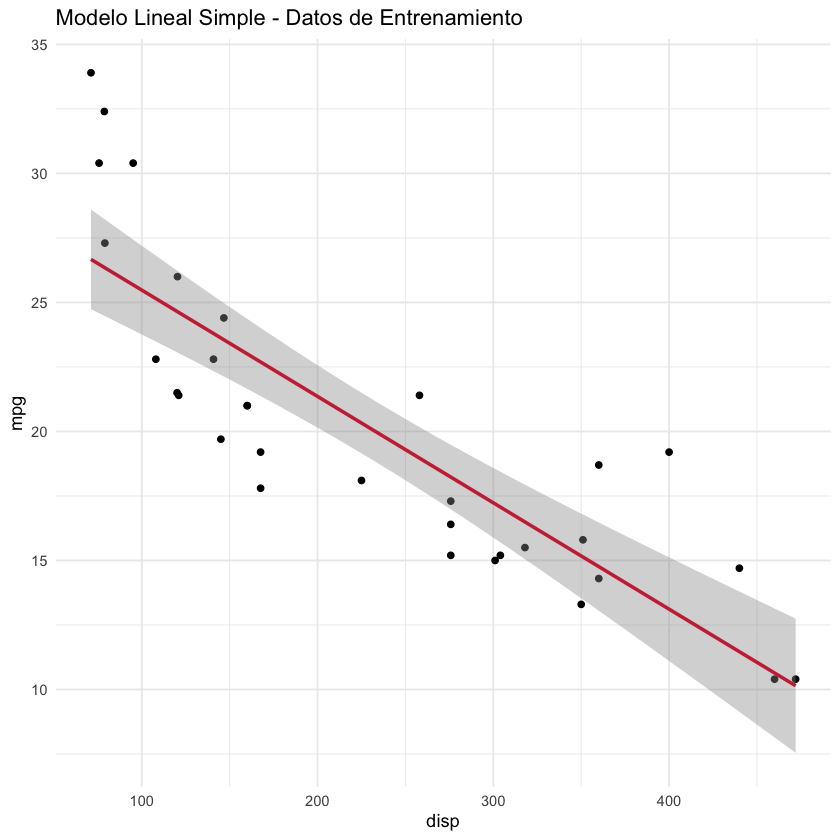

[1] 2.55

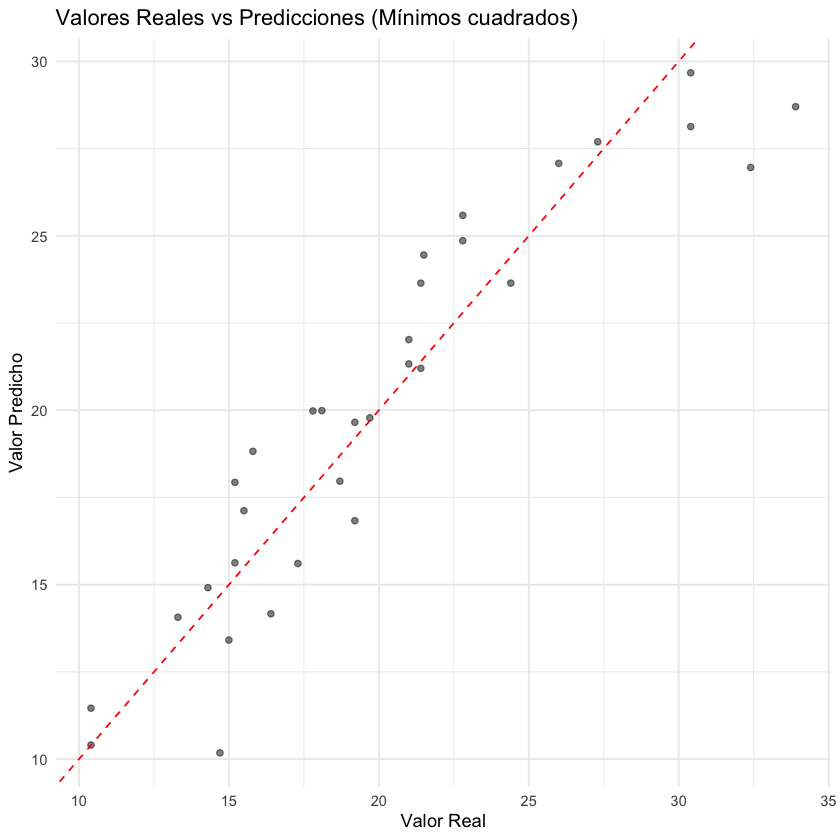

[1] 0.49

9 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) 36.03258809
cyl         -0.88222087
disp         .         
hp          -0.01316780
drat         0.21401219
wt          -2.83245977
qsec         .         
gear         .         
carb        -0.07418565

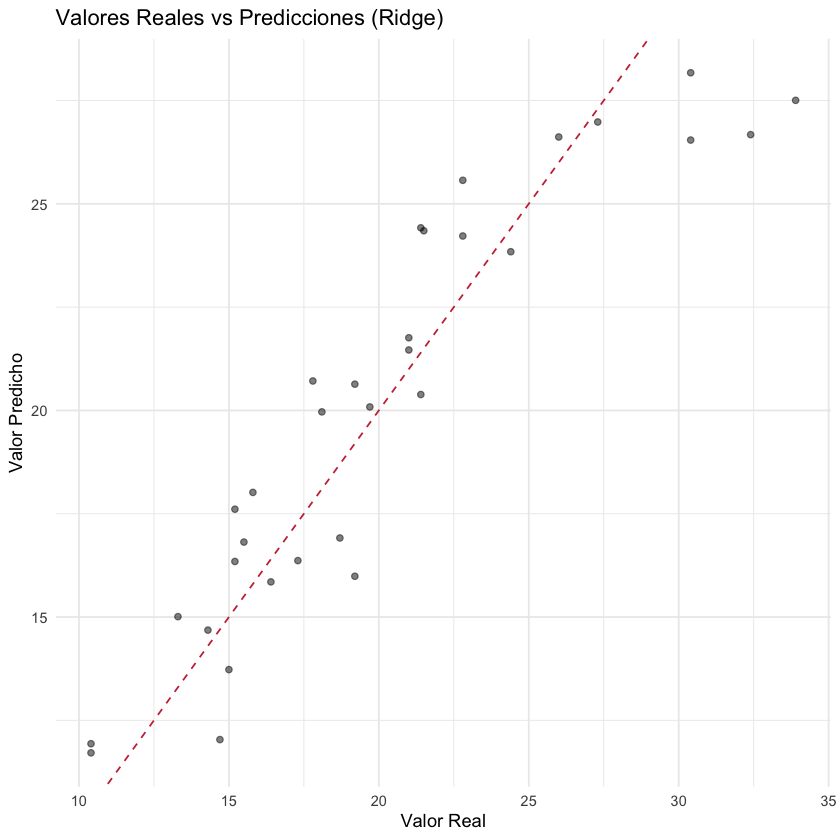

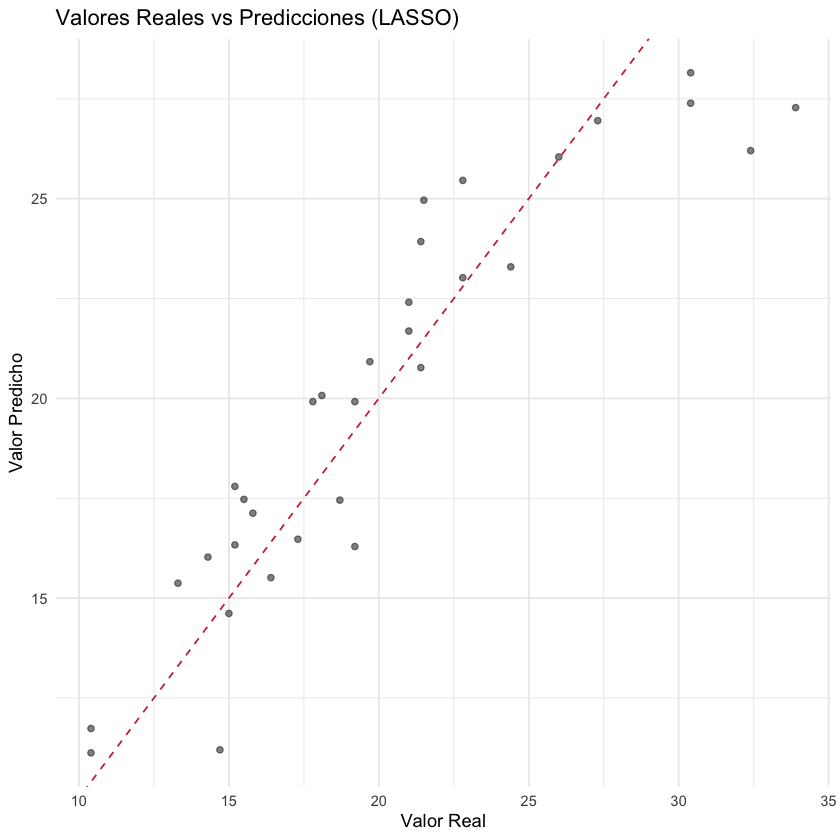

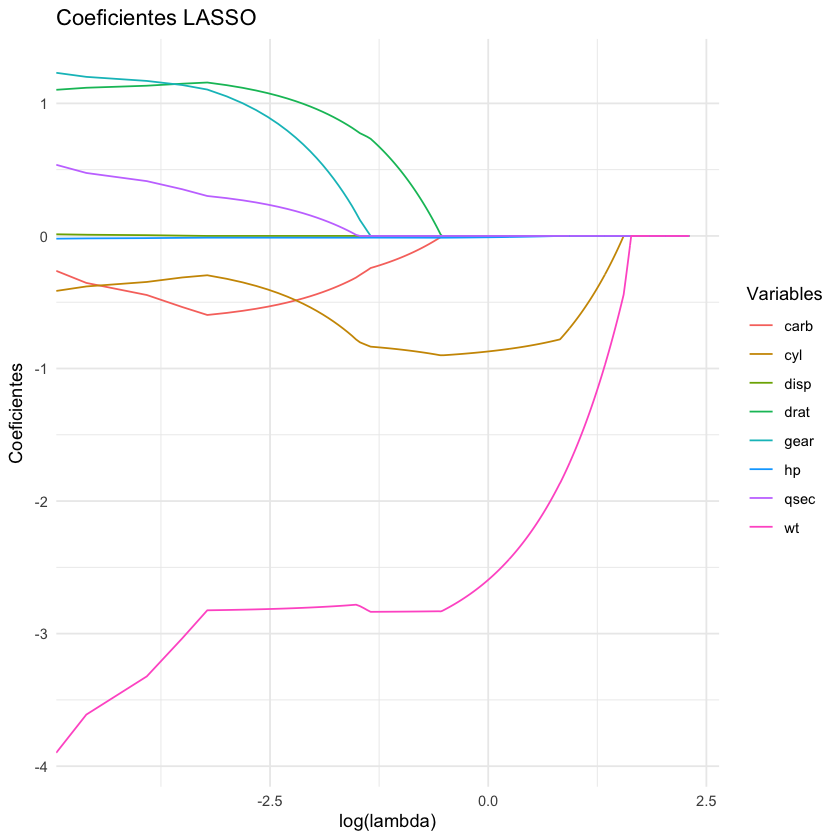

In [ ]:
data(mtcars)
head(mtcars)
#help(mtcars)
mtcars_clean <- na.omit(mtcars) 
mtcars_clean_x <- mtcars_clean %>% select(-mpg, -vs, -am)
#mtcars_clean_x <- mtcars_clean[c('disp', 'hp','drat','wt','qsec')]
mtcars_clean_y <- mtcars_clean$mpg


# REGRESION LINEAL SIMPLE
simple_model <- lm(mtcars_clean_y ~ disp, data = mtcars_clean_x) # para ajustar un modelo con mas predictores Hits + CHits

print("Intervalos de confianza al 95%:")
confint(simple_model, level = 0.95) # intervalos de confianza
summary(simple_model)

#pintamos los datos y sobre ellos la recta de regresión 
plotRLS_train <- ggplot(data = data.frame(mtcars_clean_x, mpg = mtcars_clean_y), aes(x = disp, y = mpg)) + 
                 geom_point() + geom_smooth(method = "lm", se = TRUE, color="#ca3142") + 
                 labs(title = "Modelo Lineal Simple - Datos de Entrenamiento") + theme_minimal()

plotRLS_train





# REGRESION MULTILINEAL

multi_model <- lm(mtcars_clean_y ~ ., data = mtcars_clean_x)
confint(multi_model, level = 0.95) # intervalos de confianza
summary(multi_model)

pred_multi <- predict(multi_model)

# comparacion valor esperado - valor predicho
plotLSS <- ggplot(data = data.frame(real = mtcars_clean_y, pred = pred_multi), aes(x = real, y = pred)) +
           geom_point(alpha = 0.5) +
           geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
           labs(title = "Valores Reales vs Predicciones (Mínimos cuadrados)",
                x = "Valor Real",
                y = "Valor Predicho") +
           theme_minimal()

plotLSS





# REGRESION RIDGE
lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
ridge_model <- cv.glmnet(as.matrix(mtcars_clean_x), mtcars_clean_y, alpha = 0, lambda = lam)
ridge_model$lambda.min
#plot(ridge_model)
predicciones_rg <- predict(ridge_model, newx = as.matrix(mtcars_clean_x), type = "response", s = ridge_model$lambda.min)

# comparacion valor esperado - valor predicho
plotRidge <- ggplot(data = data.frame(real = mtcars_clean_y, pred = as.vector(predicciones_rg)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (Ridge)",
                  x = "Valor Real",
                  y = "Valor Predicho") +
             theme_minimal()

plotRidge





# REGRESION LASSO
lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
lasso_model <- cv.glmnet(as.matrix(mtcars_clean_x), mtcars_clean_y, alpha = 1, lambda = lam)
lasso_model$lambda.min
coef(lasso_model, s = "lambda.min")

predicciones_la <- predict(lasso_model, newx = as.matrix(mtcars_clean_x), type = "response", s = lasso_model$lambda.min)

plotLASSO <- ggplot(data = data.frame(real = mtcars_clean_y, pred = as.vector(predicciones_la)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (LASSO)",
                  x = "Valor Real",
                  y = "Valor Predicho") +
             theme_minimal()

plotLASSO

coef_matrix <- coef(lasso_model$glmnet.fit)[-1,] # quitamos el intercepto
lambda_vals <- lasso_model$lambda

coef_df <- data.frame(lambda = rep(lambda_vals, each = nrow(coef_matrix)), 
                      coefficient = as.vector(coef_matrix), 
                      variable = rep(rownames(coef_matrix), times = length(lambda_vals)))

# trayectorias de los coeficientes
plot_coef <- ggplot(coef_df, aes(x = log(lambda), y = coefficient, color = variable)) + geom_line() + 
             labs(title = "Coeficientes LASSO", x = "log(lambda)", y = "Coeficientes", color = "Variables") + 
             theme_minimal()

print(plot_coef)

## Clasificación

En regresión logística (binaria) modelamos la probabilidad $p(X)$ con la siguiente función con salida en $[0, 1]$
\begin{equation}
p(X) = \frac{1}{1 + e^{-\left(\beta_0 + \sum_{j = 1}^p \beta_j X_j\right)}}
\end{equation}

y ajustamos el modelo usando el método de máxima verosimilitud.

En LDA asumimos que las observaciones de cada clase siguen una distribución normal multivariante y que existe una matriz de covarianza común a todas las clases, es decir, $X \sim \mathcal{N}(\mu, \Sigma)$. Aproxima el clasificador de Bayes estimando la media de la clase k-ésima, la varianza (igual para todas las clases) y la probabilidad general de que una observación elegida al azar provenga de la clase k-ésima.

En QDA (más flexible que LDA) asumimos que las observaciones de cada clase siguen una distribución normal multivariante pero que cada clase tiene su propia matriz de covarianza, $X \sim \mathcal{N}(\mu_k, \Sigma_k)$. Aproxima el clasificador de Bayes estimando la media y matriz de covarianza de la clase k-ésima, junto con la probabilidad general de que una observación elegida al azar provenga de la clase k-ésima.

In [104]:
bank <- read.csv("bank.csv", sep = ";")
bank <- na.omit(bank)
bank$y <- ifelse(bank$y == "yes", 1, 0)

train <- bank[1:4000,]
test <- bank[4001:nrow(bank),]


calcular_metricas <- function(conf_matrix) {
    tp <- conf_matrix[2,2]  # verdaderos positivos
    tn <- conf_matrix[1,1]  # verdaderos negativos
    fp <- conf_matrix[1,2]  # falsos positivos
    fn <- conf_matrix[2,1]  # falsos negativos
    
    precision <- tp / (tp + fp)
    recall <- tp / (tp + fn)  # sensitividad, TPR
    especificidad <- tn / (tn + fp)  # TNR
    fpr <- fp / (tn + fp)  # tasa de falsos positivos
    fnr <- fn / (tp + fn)  # tasa de falsos negativos
    accuracy <- (tp + tn) / sum(conf_matrix)
    
    return(list(precision = precision, recall = recall, especificidad = especificidad, 
                tasa_falsos_positivos = fpr, tasa_falsos_negativos = fnr, 
                accuracy = accuracy))
}





# REGRESION LOGISTICA
modelo_log <- glm(y ~ ., data = train, family = "binomial")

pred_log <- predict(modelo_log, newdata = test, type = "response")
pred_log_class <- ifelse(pred_log > 0.5, 1, 0)

conf_log <- table(Real = test$y, Predicho = pred_log_class)
cat("\nMatriz de confusión - Regresión Logística:\n")
print(conf_log)
metricas_log <- calcular_metricas(conf_log)
cat("\nAccuracy:", metricas_log$accuracy)





# LDA 
modelo_lda <- lda(y ~ ., data = train)
pred_lda <- predict(modelo_lda, newdata = test)
pred_lda_class <- pred_lda$class

conf_lda <- table(Real = test$y, Predicho = pred_lda_class)
cat("\nMatriz de confusión - LDA:\n")
print(conf_lda)
metricas_lda <- calcular_metricas(conf_lda)
cat("\nAccuracy:", metricas_lda$accuracy)





# QDA 
modelo_qda <- qda(y ~ ., data = train)
pred_qda <- predict(modelo_qda, newdata = test)
pred_qda_class <- pred_qda$class

conf_qda <- table(Real = test$y, Predicho = pred_qda_class)
cat("\nMatriz de confusión - QDA:\n")
print(conf_qda)
metricas_qda <- calcular_metricas(conf_qda)
cat("\nAccuracy:", metricas_qda$accuracy)


Matriz de confusión - Regresión Logística:
    Predicho
Real   0   1
   0 447  11
   1  43  20

Accuracy: 0.8963532
Matriz de confusión - LDA:
    Predicho
Real   0   1
   0 443  15
   1  34  29

Accuracy: 0.9059501
Matriz de confusión - QDA:
    Predicho
Real   0   1
   0 423  35
   1  36  27

Accuracy: 0.8637236

In [15]:
data(mtcars)
head(mtcars)
#help(mtcars)
mtcars_clean <- na.omit(mtcars) 

sub_mtcars_clean <- mtcars_clean %>% select(mpg, drat, wt, vs)

calcular_metricas <- function(conf_matrix) {
    tp <- conf_matrix[2,2]  # verdaderos positivos
    tn <- conf_matrix[1,1]  # verdaderos negativos
    fp <- conf_matrix[1,2]  # falsos positivos
    fn <- conf_matrix[2,1]  # falsos negativos
    
    precision <- tp / (tp + fp)
    recall <- tp / (tp + fn)  # sensitividad, TPR
    especificidad <- tn / (tn + fp)  # TNR
    fpr <- fp / (tn + fp)  # tasa de falsos positivos
    fnr <- fn / (tp + fn)  # tasa de falsos negativos
    accuracy <- (tp + tn) / sum(conf_matrix)
    
    return(list(precision = precision, recall = recall, especificidad = especificidad, 
                tasa_falsos_positivos = fpr, tasa_falsos_negativos = fnr, accuracy = accuracy))
}


# REGRESION LOGISTICA
modelo_log <- glm(vs ~ ., data = sub_mtcars_clean, family = "binomial")

pred_log <- predict(modelo_log, type = "response")
pred_log_class <- ifelse(pred_log > 0.5, 1, 0)

conf_log <- table(Real = sub_mtcars_clean$vs, Predicho = pred_log_class)
cat("\nMatriz de confusión - Regresión Logística:\n")
print(conf_log)
metricas_log <- calcular_metricas(conf_log)
cat("\nTasa error clasificacion:", 1 - metricas_log$accuracy)






# LDA 
modelo_lda <- lda(vs ~ ., data = sub_mtcars_clean)
pred_lda <- predict(modelo_lda)
pred_lda_class <- pred_lda$class

conf_lda <- table(Real = sub_mtcars_clean$vs, Predicho = pred_lda_class)
cat("\nMatriz de confusión - LDA:\n")
print(conf_lda)
metricas_lda <- calcular_metricas(conf_lda)
cat("\nTasa error clasificacion:", 1 - metricas_lda$accuracy)






# QDA 
modelo_qda <- qda(vs ~ ., data = sub_mtcars_clean)
pred_qda <- predict(modelo_qda)
pred_qda_class <- pred_qda$class

conf_qda <- table(Real = sub_mtcars_clean$vs, Predicho = pred_qda_class)
cat("\nMatriz de confusión - QDA:\n")
print(conf_qda)
metricas_qda <- calcular_metricas(conf_qda)
cat("\nTasa error clasificacion:", 1 - metricas_qda$accuracy)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1



Matriz de confusión - Regresión Logística:
    Predicho
Real  0  1
   0 16  2
   1  3 11

Tasa error clasificacion: 0.15625
Matriz de confusión - LDA:
    Predicho
Real  0  1
   0 17  1
   1  5  9

Tasa error clasificacion: 0.1875
Matriz de confusión - QDA:
    Predicho
Real  0  1
   0 17  1
   1  4 10

Tasa error clasificacion: 0.15625

[1] "Importancia de variables según scaling:"
              LD1
mpg   0.016616860
cyl  -0.772839295
disp -0.004355314
hp    0.014055578
drat  0.099350353
wt   -0.309469606
qsec  0.603182564
am   -1.038754669
gear  0.139447994
carb -0.174229754
Usando am tenemos un accuracy del 0.59375 
    Predicho
Real  0  1
   0 12  6
   1  7  7
Usando cyl tenemos un accuracy del 0.84375 
    Predicho
Real  0  1
   0 17  1
   1  4 10
Usando qsec tenemos un accuracy del 0.96875 
    Predicho
Real  0  1
   0 18  0
   1  1 13
Usando wt tenemos un accuracy del 0.6875 
    Predicho
Real  0  1
   0 14  4
   1  6  8
Usando am, cyl tenemos un accuracy del 0.96875 
    Predicho
Real  0  1
   0 17  1
   1  0 14
Usando am, qsec tenemos un accuracy del 0.9375 
    Predicho
Real  0  1
   0 18  0
   1  2 12
Usando am, wt tenemos un accuracy del 0.875 
    Predicho
Real  0  1
   0 15  3
   1  1 13
Usando cyl, qsec tenemos un accuracy del 0.96875 
    Predicho
Real  0  1
   0 17  1
   1  0 14
Usando cyl, wt tenemos 

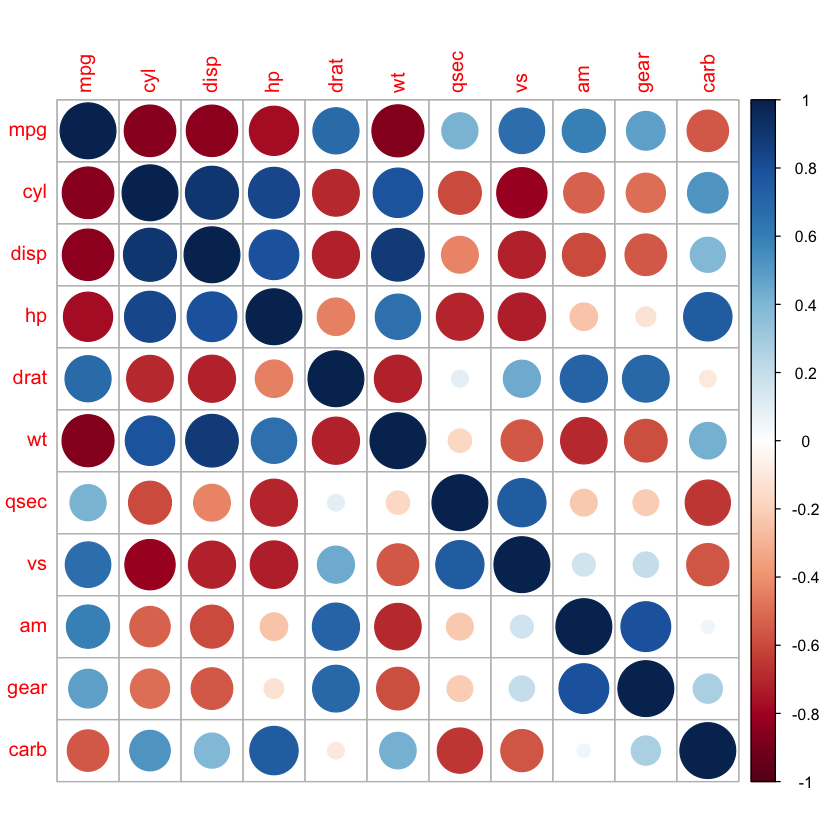

In [14]:
lda_completo <- lda(vs ~ ., data = mtcars_clean)
print("Importancia de variables según scaling:")
print(lda_completo$scaling) # am, cyl, qsec, wt,       carb, gear



library(corrplot)

cors <- cor(mtcars_clean)  # Excluir vs
corrplot(cors) # cyl, qsec, wt, (am va flojilla, poco poder predictivo)


probar_lda <- function(variables, data = mtcars_clean, respuesta = "vs") {
    formula_obj <- as.formula(paste(respuesta, "~", paste(variables, collapse = " + ")))
    modelo <- lda(formula_obj, data = data)  

    conf_matrix <- table(Real = data[[respuesta]], Predicho = predict(modelo)$class)
    cat("Usando", paste(variables, collapse = ", "), "tenemos un accuracy del", sum(diag(conf_matrix)) / sum(conf_matrix), "\n")
    print(conf_matrix)

    return
}

# varios modelos
resultado1 <- probar_lda(c('am'))
resultado2 <- probar_lda(c('cyl'))
resultado3 <- probar_lda(c('qsec'))
resultado4 <- probar_lda(c('wt'))
resultado5 <- probar_lda(c('am', 'cyl'))
resultado6 <- probar_lda(c('am', 'qsec'))
resultado7 <- probar_lda(c('am', 'wt'))
resultado8 <- probar_lda(c('cyl', 'qsec'))
resultado9 <- probar_lda(c('cyl', 'wt'))
resultado10 <- probar_lda(c('qsec', 'wt'))
resultado11 <- probar_lda(c('am', 'cyl', 'qsec'))
resultado12 <- probar_lda(c('am', 'cyl', 'wt'))
resultado13 <- probar_lda(c('am', 'qsec', 'wt'))
resultado14 <- probar_lda(c('cyl', 'qsec', 'wt'))
resultado15 <- probar_lda(c('am', 'cyl', 'qsec', 'wt'))

### Plotear modelos de clasificacion simplificados

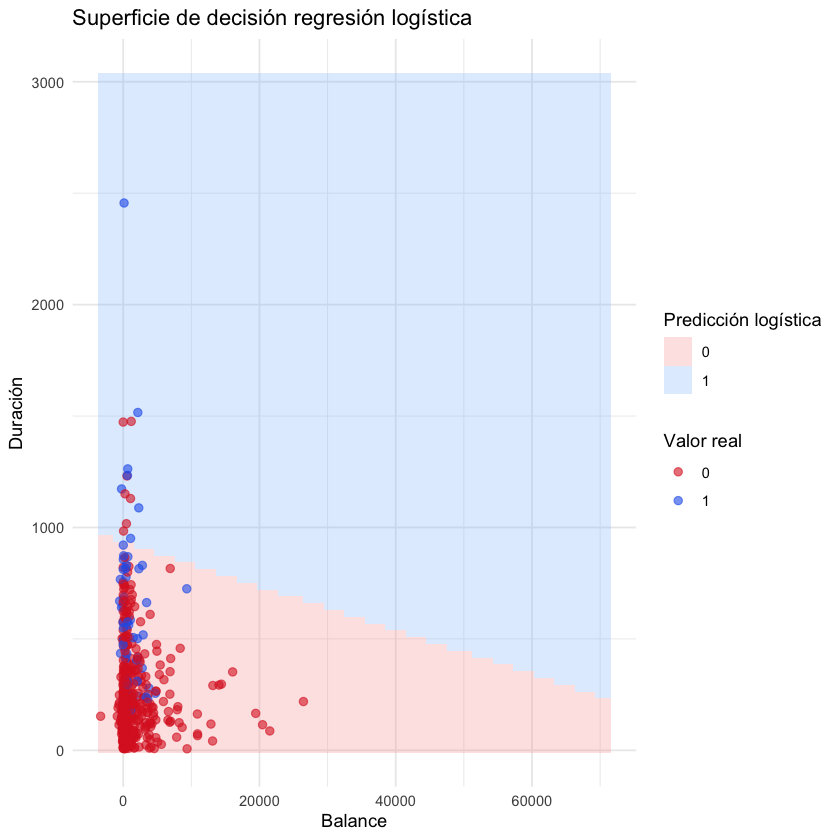

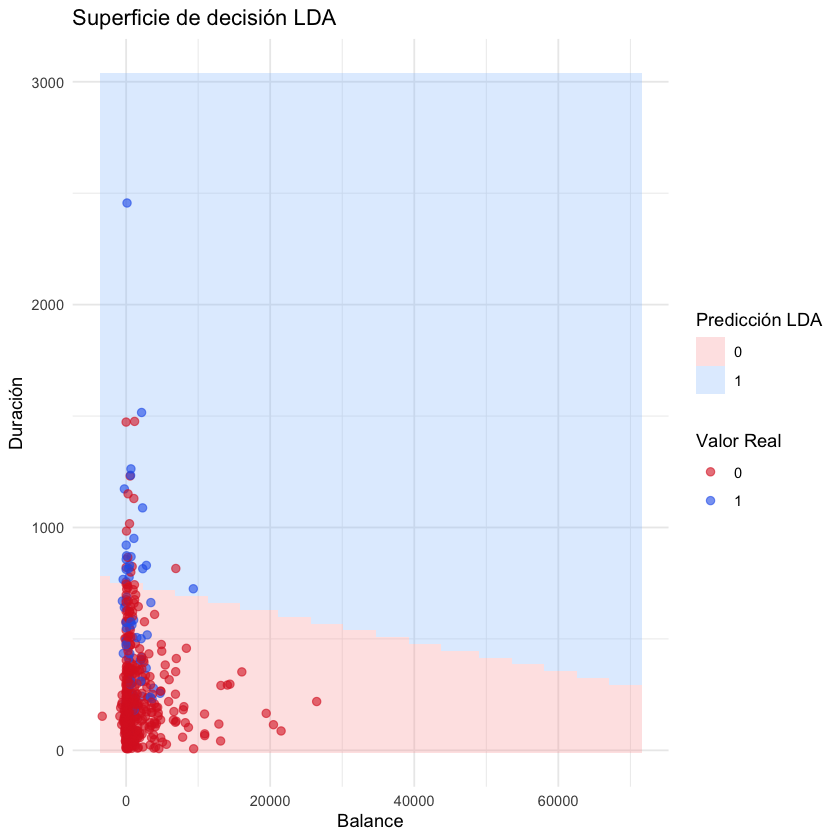

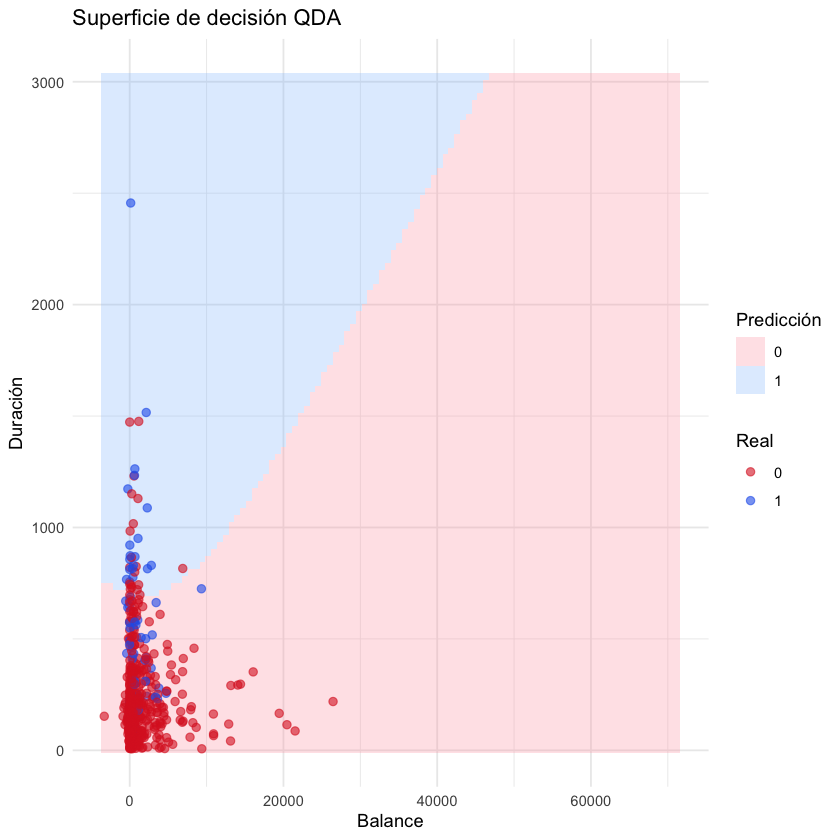

In [106]:
# modelo logístico simplificado
modelo_log_simple <- glm(y ~ balance + duration, data = train, family = "binomial")


grid <- expand.grid(balance = seq(min(bank$balance), max(bank$balance), length.out = 100), 
                    duration = seq(min(bank$duration), max(bank$duration), length.out = 100))

# predicciones
grid_pred <- predict(modelo_log_simple, newdata = grid, type = "response")
grid_class <- ifelse(grid_pred > 0.5, 1, 0)


ggplot() + geom_tile(data = cbind(grid, pred = grid_class), 
                     aes(x = balance, y = duration, fill = factor(pred)), alpha = 0.3) + 
           geom_point(data = test, aes(x = balance, y = duration, color = factor(y)), size = 2, alpha = 0.6) +
           scale_fill_manual(values = c("#FCA5A5", "#93C5FD"), name = "Predicción logística") +
           scale_color_manual(values = c("#DC2626", "#2563EB"), name = "Valor real") + 
           labs(title = "Superficie de decisión regresión logística", x = "Balance", y = "Duración") + 
           theme_minimal()





# LDA simplificado
modelo_lda_simple <- lda(y ~ balance + duration, data = train)

# Crear grid para visualización
grid <- expand.grid(balance = seq(min(bank$balance), max(bank$balance), length.out = 100), 
                    duration = seq(min(bank$duration), max(bank$duration), length.out = 100))

# predicciones
grid_pred <- predict(modelo_lda_simple, newdata = grid)$class

ggplot() + geom_tile(data = cbind(grid, pred = as.numeric(as.character(grid_pred))), 
                     aes(x = balance, y = duration, fill = factor(pred)), alpha = 0.3) + 
           geom_point(data = test, aes(x = balance, y = duration, color = factor(y)), size = 2, alpha = 0.6) + 
           scale_fill_manual(values = c("#FCA5A5", "#93C5FD"), name = "Predicción LDA") + 
           scale_color_manual(values = c("#DC2626", "#2563EB"), name = "Valor Real") + 
           labs(title = "Superficie de decisión LDA", x = "Balance", y = "Duración") + 
           theme_minimal()





# QDA con 2 variables
bank$y <- as.factor(bank$y)
train$y <- as.factor(train$y)
test$y <- as.factor(test$y)

modelo_qda_simple <- qda(y ~ balance + duration, data = train)

# Crear grid
grid <- expand.grid(balance = seq(min(bank$balance), max(bank$balance), length.out = 100), 
                    duration = seq(min(bank$duration), max(bank$duration), length.out = 100))

# predicciones
grid_pred <- predict(modelo_qda_simple, newdata = grid)$class

ggplot() + geom_tile(data = cbind(grid, pred = as.numeric(as.character(grid_pred))), 
                     aes(x = balance, y = duration, fill = factor(pred)), alpha = 0.3) + 
           geom_point(data = test, aes(x = balance, y = duration, color = factor(y)), size = 2, alpha = 0.6) + 
           scale_fill_manual(values = c("#FDA4AF", "#93C5FD"), name = "Predicción") + 
           scale_color_manual(values = c("#DC2626", "#2563EB"), name = "Real") + 
           labs(title = "Superficie de decisión QDA", x = "Balance", y = "Duración") + 
           theme_minimal()